In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
%matplotlib inline

**Setting up various arrays related to the problem**

In [ ]:
# Number of MCMC samples and number of parameters:
nsamples = 10000
npars    = 2

# Define (gaussian) width of the proposal distribution, one for each parameter:
Sigma = [0.01,0.01]
#Sigma = [0.1,0.01]
# Number of supernova bins:
nSN = 31

# Declare an empty array of the parameter values of each point.
# Parameter 0 = Omega_m
# Parameter 1 = h
# Parameter npars will be used to store the ln(likelihood)
Theta = np.empty([nsamples,npars+1])

# Utility vector to store mu(data)-mu(theory), temporarily:
Dmu = np.empty(nSN)
# Random starting point in parameter space; each parameter in range (0,1).
# Set initial likelihood to low value so next point is accepted (could compute it instead):
Theta[0,:] = [np.random.uniform(), np.random.uniform(), -1.e100]

**Reading in the data**

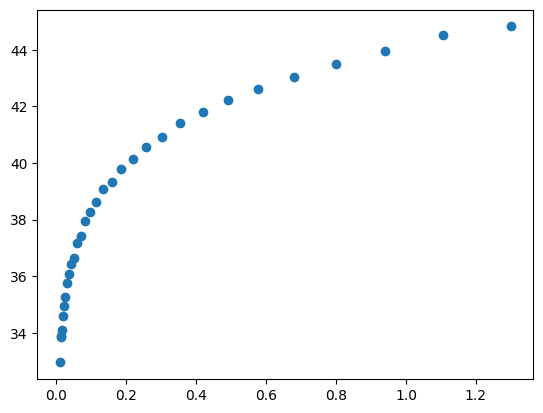

In [ ]:
# Read in the Supernova data file:
f    = open('jla_mub_0.txt', 'r') # 'r' = read only
data = np.loadtxt(f)
#delete(data,0,0) # Erases the first row (i.e. the header)
f.close()

# For convenience, define redshift bin (z) and ditance modulus (mu) arrays:
z  = data[:,0]
mu = data[:,1]

# Plot the data:
plt.plot(data[:,0],data[:,1],'o')
npts    = 300
z_plot  = np.linspace(0.01, 1.5, npts)
mu_plot = np.empty(npts)

# Read in the covariance matrix (as a list), reshape it to 31 x 31, and then invert it:
f   = open('jla_mub_covmatrix.txt', 'r') # 'r' = read only
cov = np.loadtxt(f)
cov = np.reshape(cov,(nSN,nSN))
f.close()

InvC = np.empty([nSN,nSN])
InvC = np.linalg.inv(cov)

**Setting up the model for which we will be doing parameter estimation**

In [ ]:


# Define three functions to approximate the luminosity distance and distance modulus:
# From Pen (1999).
def eta( a, Omegam ):
    "Utility function used in DL"
    s = math.pow(1.0/Omegam-1.0,1.0/3.0)
    etaval = 2.0 * math.sqrt(math.pow(s,3)+1.0) * math.pow(math.pow(a,-4)-
                                                        0.1540*s*math.pow(a,-3)+
                                                        0.4304*math.pow(s,2)*math.pow(a,-2)+
                                                        0.19097*math.pow(s,3)/a+
                                                        0.066941*math.pow(s,4),-0.125)
    return etaval

def DLstar(z,Omegam):
    "Luminosity Distance at redshift z, in Mpc/h, for flat Universe with parameters Omegam, h"
    DLval = 3000.0*(1.0+z)*(eta(1.0,Omegam)-eta(1.0/(1.0+z), Omegam))
    return DLval

def mu_model(z,Omegam,h):
    "Distance modulus at redshift z, for flat Universe with parameters Omegam, h"
    mu_model = 25.0 - 5.0*math.log10(h) + 5.0*math.log10(DLstar(z,Omegam))
    return mu_model

# Define the likelihood function:

def lnL(Omegam, h):
    "Ln of likelihood for flat Universe and SN distance modulus data"

# Treat unphysical regions by setting likelihood to (almost) zero:
    if(Omegam<=0 or h<=0):
        lnL = -1.e100
    else:

# Compute difference with theory mu at redshifts of the SN, for trial Omegam, h:
        for j in range (nSN):
            Dmu[j] = mu[j]-mu_model(z[j],Omegam,h)

# Compute ln(likelihood) assuming gaussian errors (double sum done using vector/matrix ops):
        lnL = -0.5*np.dot(Dmu,np.dot(InvC,Dmu))

    return lnL

Texting the model for a few sets of the parameters

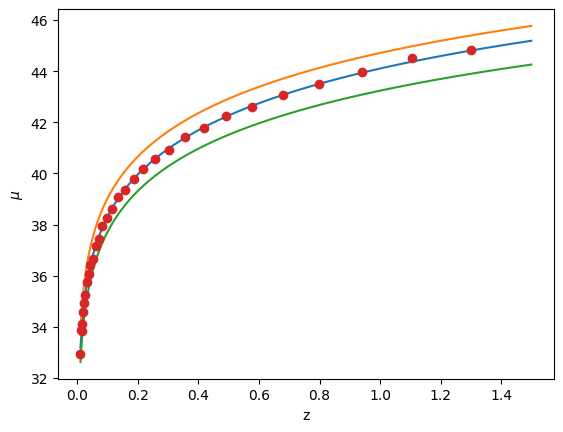

In [ ]:
# Plot a few theoretical curves on top of the data:
for i in range (npts):
    mu_plot[i] = mu_model(z_plot[i], 0.3, 0.7)
plt.plot(z_plot,mu_plot)
plt.xlabel('z')
plt.ylabel(r'$\mu$')

for i in range (npts):
    mu_plot[i] = mu_model(z_plot[i], 0.4, 0.5)
plt.plot(z_plot,mu_plot)

for i in range (npts):
    mu_plot[i] = mu_model(z_plot[i], 0.6, 0.9)
plt.plot(z_plot,mu_plot)

# Plot the data:
plt.plot(data[:,0],data[:,1],'o')

plt.show()

**Main Metropolis-Hastings block**

In [ ]:
# Draw new proposed samples from a proposal distribution, centred on old values Omegam[i-1], h[i-1]
# Accept or reject, and colour points according to ln(likelihood):

# Compute initial likelihood value:
Theta[0,npars] = lnL(Theta[0,0], Theta[0,1])

for i in range(1,nsamples):
    lnLPrevious = Theta[i-1,npars]
    OmegamProp = np.random.normal(Theta[i-1,0],Sigma[0])
    hProp      = np.random.normal(Theta[i-1,1],Sigma[1])

    lnLProp    = lnL(OmegamProp,hProp)

# Metroplis-Hastings algorithm:

    if(lnLProp > lnLPrevious):
# Accept point if likelihood has gone up:
        Theta[i,0]     = OmegamProp
        Theta[i,1]     = hProp
        Theta[i,npars] = lnLProp
    else:
# Otherwise accept it with probability given by ratio of likelihoods:
        alpha = np.random.uniform()

#        print(lnLProp,lnLPrevious,alpha)
        if(lnLProp - lnLPrevious > np.log(alpha)):
            Theta[i,0]     = OmegamProp
            Theta[i,1]     = hProp
            Theta[i,npars] = lnLProp
#            print('Accepted')
        else:
# Repeat the previous point in the chain:
            Theta[i,0]     = Theta[i-1,0]
            Theta[i,1]     = Theta[i-1,1]
            Theta[i,npars] = lnLPrevious
#            print('Rejected')

# Remove a burn in period, arbitrarily chosen to be the first 10% of the chain:
nburn = math.floor(nsamples/10)

**Visualizing the sampling**

**Scatter plots and summary statistics**

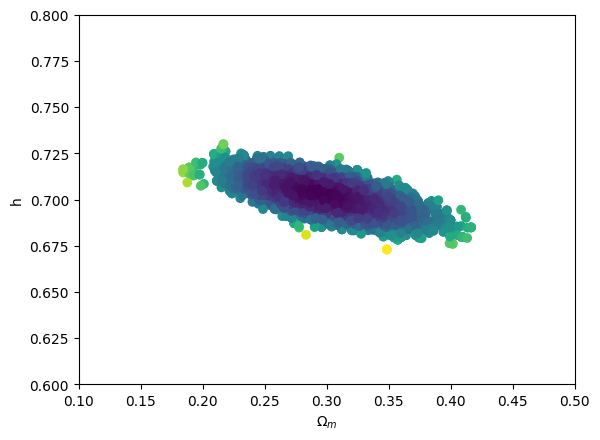

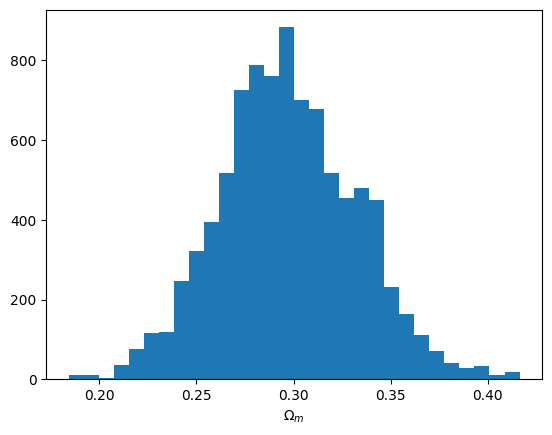

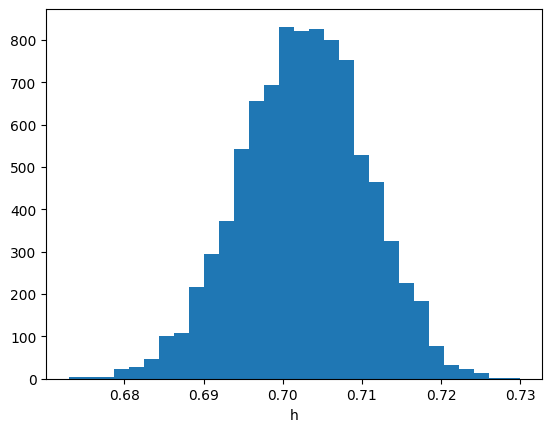

Mean of Omegam =  0.29730894613126035
Mean of h      =  0.70261913744761
Std of Omegam =  0.035368888572188215
Std of h      =  0.007918788192260664


In [ ]:
# Scatter plot of the samples:
plt.scatter(Theta[nburn:,0], Theta[nburn:,1], c = -Theta[nburn:,npars])
plt.xlim(0.1,0.5)
plt.ylim(0.6,0.8)
plt.xlabel(r'$\Omega_m$')
plt.ylabel('h')
plt.show()

# Histogram of Omegam:
plt.hist(Theta[nburn:,0],bins=30)
plt.xlabel(r'$\Omega_m$')
plt.show()

# Histogram of h:
plt.hist(Theta[nburn:,1],bins=30)
plt.xlabel('h')
plt.show()

# Print mean of parameters, after removing a burn-in of 10% of samples:

print ('Mean of Omegam = ',np.mean(Theta[nburn:nsamples,0]))
print ('Mean of h      = ',np.mean(Theta[nburn:nsamples,1]))
print ('Std of Omegam = ',np.std(Theta[nburn:nsamples,0]))
print ('Std of h      = ',np.std(Theta[nburn:nsamples,1]))